# Построение RGB-продуктов на основе спутниковых изображений

В этой практической работе будут рассмотрены методы подготовки RGB-продуктов, удобных для восприятия синоптиком, на основе нескольких каналов.
Многие функции из предыдущих работ будут переиспользованы.

In [1]:
# Библиотеки (пакеты)
import os                       # Системные функции (работа с директориями, файлами и т.п.)
import shutil                   # unix-подобные команды
import patoolib                 # Работа с архивами (7z, rar)
import numpy as np              # Работа с массивами (матрицами)
import matplotlib.pyplot as plt # Визуализация

In [2]:
os.listdir('data')

['201906111200.rar', 'bb.blk', 'll.blk']

In [7]:
"""
Набор функций для получения массива с изображениями
"""

# Удобная функция для чтения одного канала
def read_img(filename):
    with open(filename, 'rb') as file:
        first = int.from_bytes(file.read(4), byteorder='little')
        second = int.from_bytes(file.read(4), byteorder='little')
        pixs = int.from_bytes(file.read(4), byteorder='little')
        rows = int.from_bytes(file.read(4), byteorder='little')
        img = np.frombuffer(file.read(rows * pixs * 2), dtype=np.uint16)
        img = np.reshape(img, (rows, pixs))
        img = img.astype(np.float32) / 10
    return img

# Удобная функция для чтения всех каналов из архива. Возвращает словарь (ассоциативный массив)
def read_images(filename):
    img_dict = {}
    
    tmp_dir = 'tmp'

    if os.path.exists(tmp_dir):
        shutil.rmtree(tmp_dir)

    os.mkdir(tmp_dir)

    # Распаковываем архив
    patoolib.extract_archive(filename, outdir=tmp_dir, verbosity=-1, interactive=False)
    
    # Выбираем строку периода из пути к файлу (tmp/202006191200.rar)
    period = os.path.basename(filename).split('.')[0]
    
    for img_file in os.listdir(tmp_dir):
        chan_name = img_file[len(period) + 1:]
        img_dict[chan_name] = read_img(os.path.join(tmp_dir, img_file))
    
    return img_dict

In [8]:
# Получим массив с изображениями
img_dict = read_images('data/201906111200.rar')

img_dict.keys()

dict_keys(['IR_039', 'IR_108', 'IR_120', 'IR_134', 'VIS006', 'WV_062', 'WV_073'])

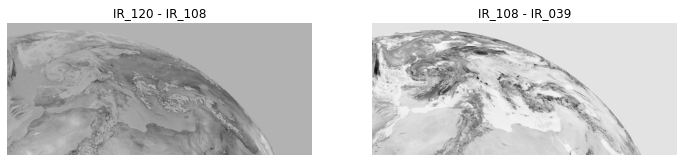

In [43]:
# Рассчитаем разности каналов
img_dict['IR_120 - IR_108'] = img_dict['IR_120'] - img_dict['IR_108']
img_dict['IR_108 - IR_039'] = img_dict['IR_108'] - img_dict['IR_039']

# Визуализируем результат
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
for i, chan_name in enumerate(['IR_120 - IR_108', 'IR_108 - IR_039']):
    ax[i].imshow(img_dict[chan_name], cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(chan_name)

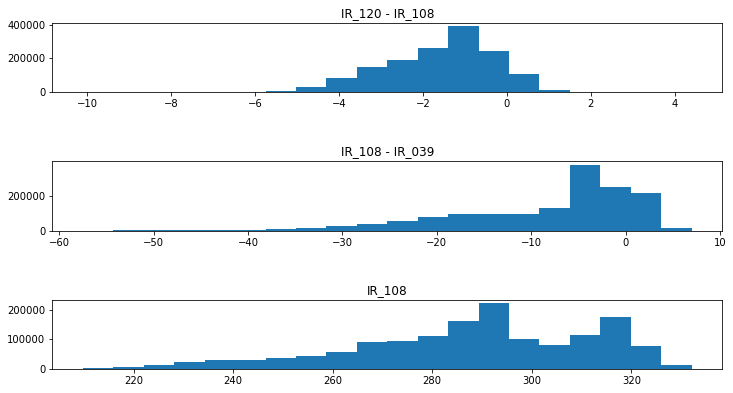

In [25]:
# Теперь изучим гистограммы значений в каждом канале.
# Это поможет определить границы нормализации

# Маска "заднего плана" - за пределами Земного диска
bg_mask = img_dict['IR_108'] == 0

fig, ax = plt.subplots(3, 1, figsize=(12, 6))

for i, chan_name in enumerate(['IR_120 - IR_108', 'IR_108 - IR_039', 'IR_108']):
    ax[i].hist(img_dict[chan_name][~bg_mask].flatten(), bins=20)
    ax[i].set_title(chan_name)
    
plt.subplots_adjust(bottom=0.1, 
                    top=0.9, 
                    hspace=1.0)

In [22]:
# Преобразуем изображения в формат uint8 с помощью нормализации


def normalize(img, min_val, max_val, bg_mask):
    """Функция для нормализации
    Args:
        img (np.ndarray): исходное изображение типа float
        min_val (float): минимальное значение для нормализации
        max_val (float): максимальное значение для нормализации
        bg_mask (np.ndarray): маска заднего плана 
            (за пределами Земного диска) той же формы, что и img
    Returns:
        np.ndarray: нормализованное изображение в формате uint8
""" 
    
    
    img_norm = np.zeros_like(img)
    
    # Учитываем только значения в пределах Земного диска
    values = img[~bg_mask].copy()

    # Уберём значения вне границ (приравняем к ближайшей границе)
    values = np.clip(values, min_val, max_val)

    # Нормализация 
    values = np.round((values - min_val) / (max_val - min_val) * 255)

    img_norm[~bg_mask] = values

    # Меняем тип для 255-битного изображения
    img_norm = img_norm.astype(np.uint8)

    return img_norm


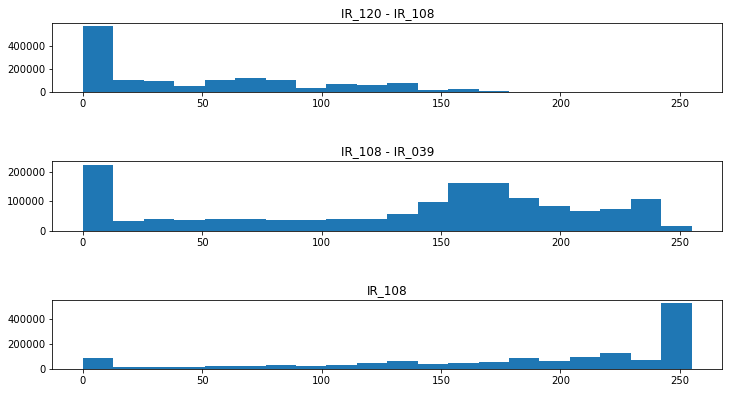

In [50]:
# Границы нормализации для каждого канала (нужно подбирать по гистограмме)
bounds = {
    'IR_120 - IR_108': (-2, 2),
    'IR_108 - IR_039': (-20, 5),
    'IR_108': (240, 300)
}

# Для сохранения нормализованных изображений
img_norm = {}

# Границы нормализации для каждого канала
for chan_name, (min_val, max_val) in bounds.items():
    img_norm[chan_name] = normalize(img_dict[chan_name], min_val, max_val, bg_mask)
    
# Снова рисуем гистограммы. Что изменилось?
fig, ax = plt.subplots(3, 1, figsize=(12, 6))

for i, chan_name in enumerate(['IR_120 - IR_108', 'IR_108 - IR_039', 'IR_108']):
    ax[i].hist(img_norm[chan_name][~bg_mask].flatten(), bins=20)
    ax[i].set_title(chan_name)
    
plt.subplots_adjust(bottom=0.1, 
                    top=0.9, 
                    hspace=1.0)



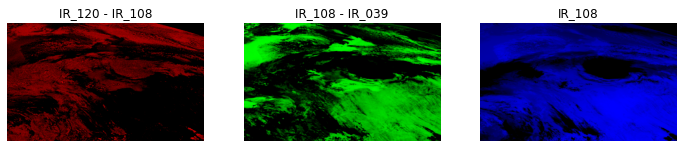

In [51]:
# Визуализируем результат - только область для примера
fig, ax = plt.subplots(1, 3, figsize=(12, 6))

zeros = np.zeros_like(img_norm['IR_108'])
red = np.stack([img_norm['IR_120 - IR_108'], zeros, zeros], axis=-1)
green = np.stack([zeros, img_norm['IR_108 - IR_039'], zeros], axis=-1)
blue = np.stack([zeros, zeros, img_norm['IR_108']], axis=-1)

chan_names = ['IR_120 - IR_108', 'IR_108 - IR_039', 'IR_108']

for i, (chan_name, img) in enumerate(zip(chan_names, (red, green, blue))):
    ax[i].imshow(img[100:400, 500:1000], cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(chan_name)

(-0.5, 499.5, 299.5, -0.5)

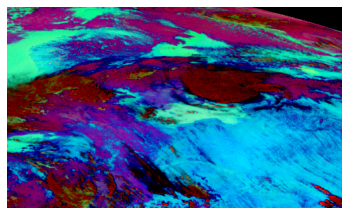

In [52]:
# Строим RGB-изображение
img_rgb = red + green + blue

# Визуализируем результат (ограниченная область)
plt.imshow(img_rgb[100:400, 500:1000])
plt.axis('off')

(-0.5, 2311.5, 999.5, -0.5)

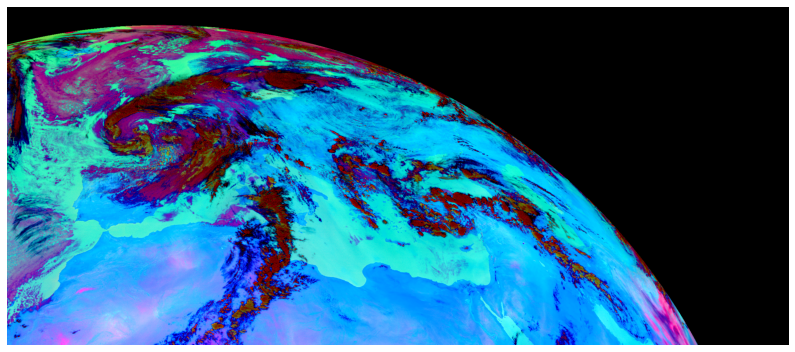

In [53]:
# Визуализируем итоговое изображение целиком
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
ax.imshow(img_rgb)
ax.axis('off')

# Задание

1. Цветовая палитра зависит от выбраных границ нормализации. Их следует подобрать таким образом, чтобы облачность каждого типа имела свой цвет (оттенок). Рекомендуется либо исходить из конкретной задачи (например, отделить туман от остальной области, выделить его голубым цветом) или широко использующихся в научном сообществе методик.

2. Чтобы RGB-продукт было удобно использовать, необходимо наложить его на карту, провести параллели и меридианы (см. предыдущий урок).
